라이브러리 로드

In [2]:
import torch 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import pytorch_model_summary

GPU 설정

In [3]:
device=torch.device('cuda'if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

데이터 로드

In [4]:
transform=transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,),(0.5))])

In [5]:
trainset=datasets.FashionMNIST(root='content',
train=True,download=True,
transform=transform)

testset=datasets.FashionMNIST(root='content',
train=False,download=True,
transform=transform)

In [6]:
print(len(trainset))
print(len(testset))

60000
10000


In [7]:
train_loader=DataLoader(trainset,batch_size=128,shuffle=True,num_workers=6)
test_loader=DataLoader(testset,batch_size=128,shuffle=False,num_workers=6)

In [8]:
images,labels=next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [9]:
total_batch=len(train_loader)
print(total_batch)

469


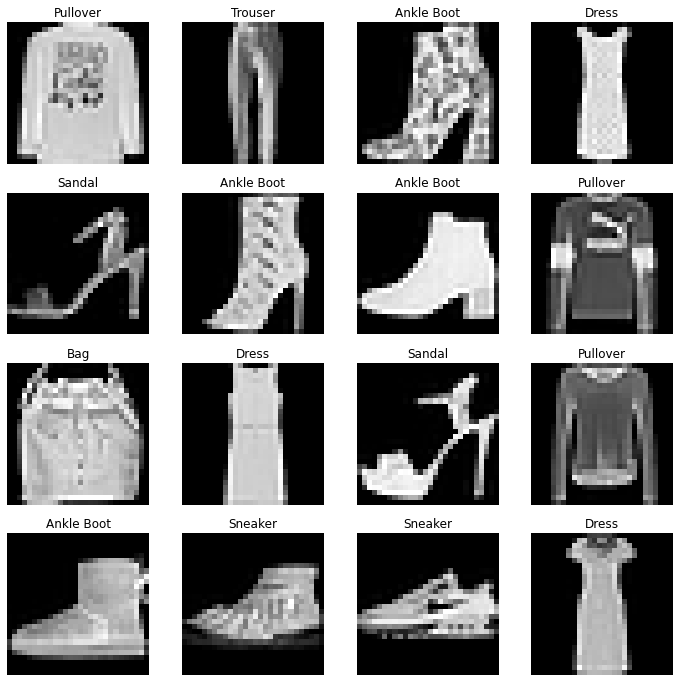

In [10]:
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

figure=plt.figure(figsize=(12,12))
cols,rows=4,4
for i in range(1,cols*rows+1):
    image=images[i].squeeze()
    label_idx=labels[i].item()
    label=classes[label_idx]

    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image,cmap='gray')

plt.show()

학습된 모델(pretrained model) 로드

In [11]:
model = models.efficientnet_b0(pretrained=True)
model.parameters

<bound method Module.parameters of EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
 

모델 정의

In [12]:
class MyEfficientNet(nn.Module):
    def __init__(self):
        super(MyEfficientNet,self).__init__()
        self.conv=nn.Conv2d(1,3,3).to(device)
        self.network=model.to(device)
        self.lin=nn.Linear(1000,10).to(device)
        
    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv(x)),(2,2)).to(device)
        x=F.relu(self.network(x)).to(device)
        x=F.softmax(self.lin(x),dim=1).to(device)
        return x

In [13]:
mynet=MyEfficientNet()
mynet.to(device)
print(mynet)

MyEfficientNet(
  (conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (network): EfficientNet(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): ConvNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            

In [14]:
params=list(mynet.parameters())
print(len(params))
print(params[0].size())

217
torch.Size([3, 1, 3, 3])


In [15]:
print(pytorch_model_summary.summary(mynet, torch.zeros(128, 1, 128, 128).to(device), show_input=True))

--------------------------------------------------------------------------
      Layer (type)            Input Shape         Param #     Tr. Param #
          Conv2d-1     [128, 1, 128, 128]              30              30
    EfficientNet-2       [128, 3, 63, 63]       5,288,548       5,288,548
          Linear-3            [128, 1000]          10,010          10,010
Total params: 5,298,588
Trainable params: 5,298,588
Non-trainable params: 0
--------------------------------------------------------------------------


손실함수와 옵티마이저

In [16]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(mynet.parameters(), lr=0.0001, momentum=0.9)

TensorBoard 설정

In [17]:
from torch.utils.tensorboard import SummaryWriter

# 기본 `log_dir` 은 "runs"이며, 여기서는 더 구체적으로 지정하였습니다
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

2022-06-17 13:50:23.407468: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


TensorBoard 기록

In [20]:
# 임의의 학습 이미지를 가져옵니다
dataiter = iter(train_loader)
images, labels = dataiter.next()
images=images.to(device)
labels=labels.to(device)

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# tensorboard에 기록합니다.
writer.add_image('four_fashion_mnist_images', img_grid)

In [21]:
writer.add_graph(mynet, images)
writer.close()

In [22]:
%tensorboard --logdir=runs

UsageError: Line magic function `%tensorboard` not found.


모델 학습

In [23]:
# epoch 수는 50 
for epoch in range(50):
    running_loss=0.0

    for i, data in enumerate(train_loader,0):
        # 데이터 입력
        inputs, labels=data
        inputs=inputs.to(device)
        labels=labels.to(device)
        # Gradient -> 0
        optimizer.zero_grad()
        # 순전파+역전파+최적화 
        outputs=mynet(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss +=loss.item()

        if i % 100 == 99:
            # 학습 중 손실(running loss)을 기록
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(train_loader) + i)
            print('Epoch: {}, Iter: {}, Loss:{}'.format(epoch+1,i+1,running_loss/1000))
            running_loss=0.0

Epoch: 1, Iter: 100, Loss:0.23062645745277405
Epoch: 1, Iter: 200, Loss:0.23019900488853454
Epoch: 1, Iter: 300, Loss:0.23015487599372864
Epoch: 1, Iter: 400, Loss:0.22975945925712585
Epoch: 2, Iter: 100, Loss:0.22936441230773927
Epoch: 2, Iter: 200, Loss:0.229061710357666
Epoch: 2, Iter: 300, Loss:0.22875295186042785
Epoch: 2, Iter: 400, Loss:0.22823749351501466
Epoch: 3, Iter: 100, Loss:0.22740442419052123
Epoch: 3, Iter: 200, Loss:0.22695455455780028
Epoch: 3, Iter: 300, Loss:0.22638255977630614
Epoch: 3, Iter: 400, Loss:0.2256512532234192
Epoch: 4, Iter: 100, Loss:0.22473069834709167
Epoch: 4, Iter: 200, Loss:0.22381484651565553
Epoch: 4, Iter: 300, Loss:0.22370011615753174
Epoch: 4, Iter: 400, Loss:0.22317521691322326
Epoch: 5, Iter: 100, Loss:0.22163659477233888
Epoch: 5, Iter: 200, Loss:0.22083321380615234
Epoch: 5, Iter: 300, Loss:0.2201430687904358
Epoch: 5, Iter: 400, Loss:0.21919775819778442
Epoch: 6, Iter: 100, Loss:0.21883191084861756
Epoch: 6, Iter: 200, Loss:0.2182302660

모델 테스트

In [29]:
correct=0
total=0

with torch.no_grad():
    for data in test_loader:
        images, labels=data
        images=images.to(device)
        labels=labels.to(device)
        outputs=mynet(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print(correct/total*100)

72.25


TensorBoard로 학습된 모델 평가

In [31]:
# 1. 예측 확률을 test_size x num_classes 텐서로 가져옵니다
# 2. 예측 결과를 test_size 텐서로 가져옵니다
class_probs = []
class_label = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        output = mynet(images)
        class_probs_batch = [el for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# 헬퍼 함수
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    0부터 9까지의 "class_index"를 가져온 후 해당 정밀도-재현율(precision-recall)
    곡선을 그립니다
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# 모든 정밀도-재현율(precision-recall; pr) 곡선을 그립니다
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs,test_label)

In [32]:
%tensorboard --logdir=runs

UsageError: Line magic function `%tensorboard` not found.
